In [65]:
import math
from neo4j import GraphDatabase
import csv
import pandas as pd

In [66]:


uri = "neo4j://localhost:7687"
user = "neo4j"
password = "EAFSDd8zrRrc66g"

driver = GraphDatabase.driver(uri, auth=(user, password))

# Define the calculate_decay_factor function
def calculate_decay_factor(tx, assignee, component):
    # Calculate the average solving time of bugs for this assignee and component
    avg_solving_time = tx.run("MATCH (a:assignee{name: $assignee})<-[:assignedTo]-(b:bugId)-[:belongsToComponent]->(c:component{name: $component}),(b)-[:solvedin]->(s:solving_time) "
                              "RETURN avg(toInteger(s.name)) AS avg_solving_time",
                              assignee=assignee, component=component).single()["avg_solving_time"]

    # Calculate the total decay factor for all bugs resolved by this assignee in this component
    total_decay_factor = 0
    result = tx.run("MATCH (a:assignee{name: $assignee})<-[:assignedTo]-(b:bugId)-[:belongsToComponent]->(c:component{name: $component}),(b)-[e:decay_time]->(d:decay_time) "
                    "RETURN e.weight AS days_diff_from_today",
                    assignee=assignee, component=component)
    for record in result:
        days_diff_from_today = record["days_diff_from_today"]
        if avg_solving_time == 0:
            decay_factor = 0
        else:
            decay_factor = math.exp(-days_diff_from_today / avg_solving_time)
        total_decay_factor += decay_factor

    # Calculate the average decay factor for this assignee in this component
    num_bugs = tx.run("MATCH (a:assignee{name: $assignee})<-[:assignedTo]-(b:bugId)-[:belongsToComponent]->(c:component{name: $component}) "
                      "RETURN count(b) AS num_bugs",
                      assignee=assignee, component=component).single()["num_bugs"]
    if num_bugs == 0:
        avg_decay_factor = 0
    else:
        avg_decay_factor = total_decay_factor / num_bugs

    return avg_decay_factor

# Define the calculate_expertise_score function
def calculate_expertise_score(tx, assignee, component):
    # Calculate the expertise score for this assignee
    result = tx.run("MATCH (a:Assignee{name: $assignee})-[e:EXPERTISE]->(c:Component{name: $component}) "
                    "RETURN e.weight AS expertise_score",
                    assignee=assignee, component=component).single()
    if result is None:
        return 0
    else:
        # print(result["expertise_score"])
        return result["expertise_score"]

# Define the calculate_interaction_trust function
def calculate_Bug_Resolution_Performance_Index(tx, assignee):
    result = tx.run("MATCH (a1:Assignee{name: $assignee})-[t:TRUST]->(i:BugResolutionPerformanceIndex) "
                    "RETURN (t.weight) AS Bug_Resolution_Performance_Index",
                    assignee=assignee).single()
    if result is None:
        return 0
    else:
        # print(result["interaction_trust"])
        return result["Bug_Resolution_Performance_Index"]

def calculate_credibility_score(a,b,c,file_name):
    # Retrieve all assignees and their corresponding components from the database
    with driver.session() as session:
        assignee_components = session.run("MATCH (a:assignee)<-[:assignedTo]-(b:bugId)-[:belongsToComponent]->(c:component) "
                                      "RETURN DISTINCT a.name AS assignee, c.name AS component").data()


    with open(f"credibility_score/{file_name}", mode='w', newline='') as file:
        writer = csv.writer(file)

        # Write the header row
        writer.writerow(['Assignee', 'Component', 'credibility_score'])

        # Iterate over each assignee-component pair and calculate the weight
        for ac in assignee_components:
            assignee = ac["assignee"]
            component = ac["component"]
            decay_factor = calculate_decay_factor(session, assignee, component)
            Bug_Resolution_Performance_Index = calculate_Bug_Resolution_Performance_Index(session, assignee)
            expertise_score = calculate_expertise_score(session, assignee, component)
            credibility_score = a * Bug_Resolution_Performance_Index +b * expertise_score + c * decay_factor
            # Write the row to the CSV file
            writer.writerow([assignee, component, credibility_score])
    

In [67]:
calculate_credibility_score(0.25,0.5,0.25,'credits_25_5_25')
calculate_credibility_score(0.2,0.6,0.2,'credits_2_6_2')
calculate_credibility_score(0.3,0.4,0.3,'credits_3_4_3')
calculate_credibility_score(0.3,0.3,0.4,'credits_3_3_4')

In [80]:
from neo4j import GraphDatabase

def recommend_developers_for_bug(bug_id,file_path,n):
    # Connect to Neo4j database
    uri = "neo4j://localhost:7687"
    user = "neo4j"
    password = "EAFSDd8zrRrc66g"

    driver = GraphDatabase.driver(uri, auth=(user, password))
    with driver.session() as session:
        # Find bug-related properties
        bug_properties_query = (
            "MATCH (s:severity)<-[k:hasSeverity]-(b:bugId{name: $bug_id}),(p:priority)<-[h:hasPriority]-(b) ,(m:component)<-[:belongsToComponent]-(b),(pc:product)<-[:belongsToProduct]-(b:bugId{name: $bug_id})"
            "RETURN p.name AS priority, s.name AS severity, m.name AS component,pc.name as product"
        )
        bug_properties_result = session.run(bug_properties_query, bug_id=bug_id).single()
        priority = bug_properties_result["priority"]
        severity = bug_properties_result["severity"]
        component = bug_properties_result["component"]
        product=bug_properties_result["product"]

        # Find developers who solved similar bugs
        similar_bugs_query = (
            "MATCH (bug:bugId)-[:hasPriority]->(:priority {name: $priority}) ,(bug:bugId)-[:hasSeverity]->(:severity {name: $severity}),(bug:bugId)-[:belongsToComponent]->(c:component {name: $component}),(bug:bugId)-[:assignedTo]->(a:assignee),(pc:product{name:$product})<-[:belongsToProduct]-(bug)"
            "Where bug.name <> $bug_id "
           "Return Distinct(a.name) as developers"
        )
        similar_bugs_results = session.run(similar_bugs_query, bug_id=bug_id, priority=priority, severity=severity, component=component,product=product)

        # Rank developers by number of similar bugs solved
        df = pd.read_csv(file_path)
        ranked_developers = []
        for result in similar_bugs_results:
            developer = result["developers"]
            credibility_score = df.loc[(df['Assignee'] == developer) & (df['Component'] == component), 'credibility_score'].iloc[0]
            ranked_developers.append((developer, credibility_score))
        # print(len(ranked_developers))
        ranked_developers = sorted(ranked_developers, key=lambda x: x[1], reverse=True)
        return ranked_developers[:n]

In [97]:
result=recommend_developers_for_bug('722395','credibility_score/credits_3_4_3',5)
for r in result:
    print(r)
print('\n')
result=recommend_developers_for_bug('722395','credibility_score/credits_3_4_3',10)
for r in result:
    print(r)
print('\n')
result=recommend_developers_for_bug('722395','credibility_score/credits_3_4_3',15)
for r in result:
    print(r)
print('\n')

('mhoye@mozilla.com', 0.5163864328550235)
('kmoir@mozilla.com', 0.4442874894139053)
('dveditz@mozilla.com', 0.4422075242896575)
('scabral@mozilla.com', 0.4289156626506024)
('mozillamarcia.knous@gmail.com', 0.4281543984155802)


('mhoye@mozilla.com', 0.5163864328550235)
('kmoir@mozilla.com', 0.4442874894139053)
('dveditz@mozilla.com', 0.4422075242896575)
('scabral@mozilla.com', 0.4289156626506024)
('mozillamarcia.knous@gmail.com', 0.4281543984155802)
('ian@hixie.ch', 0.4233781278962002)
('lizhenry@gmail.com', 0.4230558598051471)
('ashish@mozilla.com', 0.4219879518072289)
('timeless@bemail.org', 0.4163048417719048)
('asa@mozilla.com', 0.4156163113994439)


('mhoye@mozilla.com', 0.5163864328550235)
('kmoir@mozilla.com', 0.4442874894139053)
('dveditz@mozilla.com', 0.4422075242896575)
('scabral@mozilla.com', 0.4289156626506024)
('mozillamarcia.knous@gmail.com', 0.4281543984155802)
('ian@hixie.ch', 0.4233781278962002)
('lizhenry@gmail.com', 0.4230558598051471)
('ashish@mozilla.com', 0.421987

In [94]:
import random

def accuracy_of_recommendation_algorithm(file_path,n):
    # Connect to Neo4j database
    uri = "neo4j://localhost:7687"
    user = "neo4j"
    password = "EAFSDd8zrRrc66g"
    driver = GraphDatabase.driver(uri, auth=(user, password))

    with driver.session() as session:
        # Pick 500 random bugs
        random_bugs_query = (
            "MATCH (bug:bugId) "
            "WITH bug, rand() AS r "
            "ORDER BY r "
            "LIMIT 500 "
            "RETURN bug.name AS bug_id"
        )
        random_bugs_results = session.run(random_bugs_query)

        # Initialize count of correct guesses
        correct_guesses = 0

        for result in random_bugs_results:
            bug_id = result["bug_id"]

            # Get recommended developers for this bug
            recommended_developers = recommend_developers_for_bug(bug_id,file_path,n)

            # Check if omitted developer is in recommended list
            omitted_developer_query = (
                "MATCH (bug:bugId {name: $bug_id})-[:assignedTo]->(omitted_developer:assignee) "
                "RETURN omitted_developer.name AS name"
            )
            omitted_developer_result = session.run(omitted_developer_query, bug_id=bug_id).single()
            omitted_developer = omitted_developer_result["name"] if omitted_developer_result else None

            if omitted_developer and omitted_developer in [developer[0] for developer in recommended_developers]:
                correct_guesses += 1

        # Calculate accuracy of algorithm
        accuracy = correct_guesses / 500.0
        
        return accuracy

In [95]:
accuracy_25_5_25_20=accuracy_of_recommendation_algorithm('credibility_score/credits_25_5_25',20)
print(accuracy_25_5_25_20)
accuracy_2_6_2_20=accuracy_of_recommendation_algorithm('credibility_score/credits_2_6_2',20)
print(accuracy_2_6_2_20)
accuracy_3_4_3_20=accuracy_of_recommendation_algorithm('credibility_score/credits_3_4_3',20)
print(accuracy_3_4_3_20)
accuracy_3_3_4_20=accuracy_of_recommendation_algorithm('credibility_score/credits_3_3_4',20)
print(accuracy_3_3_4_20)
accuracy_25_5_25_10=accuracy_of_recommendation_algorithm('credibility_score/credits_25_5_25',10)
print(accuracy_25_5_25_10)
accuracy_2_6_2_10=accuracy_of_recommendation_algorithm('credibility_score/credits_2_6_2',10)
print(accuracy_2_6_2_10)
accuracy_3_4_3_10=accuracy_of_recommendation_algorithm('credibility_score/credits_3_4_3',10)
print(accuracy_3_4_3_10)
accuracy_3_3_4_10=accuracy_of_recommendation_algorithm('credibility_score/credits_3_3_4',10)
print(accuracy_3_3_4_10)
accuracy_25_5_25_30=accuracy_of_recommendation_algorithm('credibility_score/credits_25_5_25',30)
print(accuracy_25_5_25_30)
accuracy_2_6_2_30=accuracy_of_recommendation_algorithm('credibility_score/credits_2_6_2',30)
print(accuracy_2_6_2_30)
accuracy_3_4_3_30=accuracy_of_recommendation_algorithm('credibility_score/credits_3_4_3',30)
print(accuracy_3_4_3_30)
accuracy_3_3_4_30=accuracy_of_recommendation_algorithm('credibility_score/credits_3_3_4',30)
print(accuracy_3_3_4_30)


0.462
0.418
0.482
0.506
0.246


KeyboardInterrupt: 

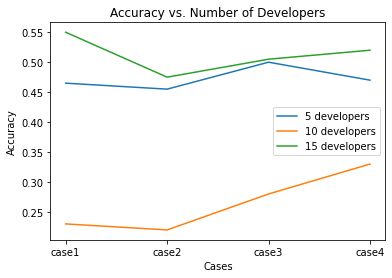

In [ ]:
import matplotlib.pyplot as plt

    # data for x-axis and y-axis
x = ['case1', 'case2', 'case3', 'case4']
y1 = [accuracy_25_5_25_20,accuracy_2_6_2_20, accuracy_3_4_3_20, accuracy_3_3_4_20] # accuracy for 5 developers
y2 = [accuracy_25_5_25_10,accuracy_2_6_2_10, accuracy_3_4_3_10, accuracy_3_3_4_10] # accuracy for 10 developers
y3 = [accuracy_25_5_25_30, accuracy_2_6_2_30, accuracy_3_4_3_30, accuracy_3_3_4_30] # accuracy for 15 developers

    # plot the lines
plt.plot(x, y1, label='5 developers')
plt.plot(x, y2, label='10 developers')
plt.plot(x, y3, label='15 developers')

    # set the title and labels
plt.title('Accuracy vs. Number of Developers')
plt.xlabel('Cases')
plt.ylabel('Accuracy')

    # add a legend
plt.legend()

    # show the plot
plt.show()